I need to implement the same algorithm as the one provided by Fiji 


[![Remove outliers](static/remove_outliers.png)](https://imagejdocu.tudor.lu/gui/process/noise#:~:text=and%20pepper%20noise.-,Remove%20Outliers,pixels%20of%20a%20CCD%20image)

[Anders library](https://github.com/neutronimaging/scripts/blob/master/python/amglib/Test_spot_clean.ipynb)


# Workflow

1. create fake data set with gamma spots
2. implement algorithm
3. visualize correction (before and after)

## Create fake data set 

In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from PIL import Image

import skimage
# from skimage.filters import median
from skimage.filters.rank import median
from skimage.morphology import disk

In [125]:
image_width = 50
image_height = 50
total_nbr_of_pixels = image_height * image_width

In [17]:
image1 = np.random.rand(image_height, image_width) * 10
print(f"shape of image1: {np.shape(image1)}")

# random location of Gammas
number_of_gammas = 10
list_x = np.random.rand(number_of_gammas) * image_width
list_y = np.random.rand(number_of_gammas) * image_height
list_x = [int(_x) for _x in list_x]
list_y = [int(_y) for _y in list_y]

number_of_dead_pixels = 8
list_dead_x = np.random.rand(number_of_dead_pixels) * image_width
list_dead_y = np.random.rand(number_of_dead_pixels) * image_height
list_dead_x = [int(_x) for _x in list_dead_x]
list_dead_y = [int(_y) for _y in list_dead_y]


# print(f"Random gammas coordinated (y,x):")
for _y, _x in zip(list_y, list_x):
#     print(f"-> ({_y}, {_x})")
    gamma_value = np.random.randint(10) + 30
    image1[_y, _x] = gamma_value    
    
for _y, _x in zip(list_dead_y, list_dead_x):
    image1[_y, _x] = 0
    
image1 = image1.astype(np.uint16)

shape of image1: (50, 50)


<IPython.core.display.Javascript object>


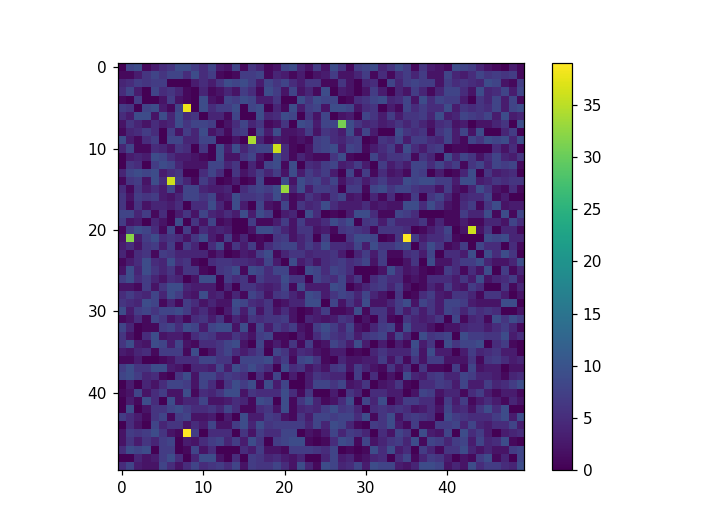

In [18]:
fig = plt.figure(0)
plot1 = plt.imshow(image1)
plt.colorbar(plot1)


### Gamma filtering

In [24]:
radius_of_disk = 2
footprint = disk(radius_of_disk)

median_of_image = median(image1, footprint=footprint, out=None)

<IPython.core.display.Javascript object>


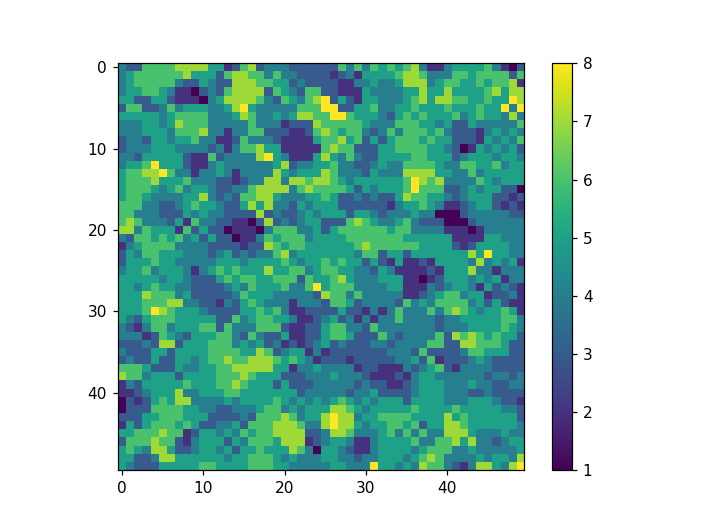

In [26]:
fig2 = plt.figure(1)

plot1 = plt.imshow(median_of_image)
plt.colorbar(plot1)


### Image versus corrected for a given threshold 

In [67]:
fig3, axs = plt.subplots(1,2)

plot1 = axs[0].imshow(image1)
fig.colorbar(plot1, ax=axs[0])

plot2 = axs[1].imshow(image_corrected)
fig.colorbar(plot2, ax=axs[1])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


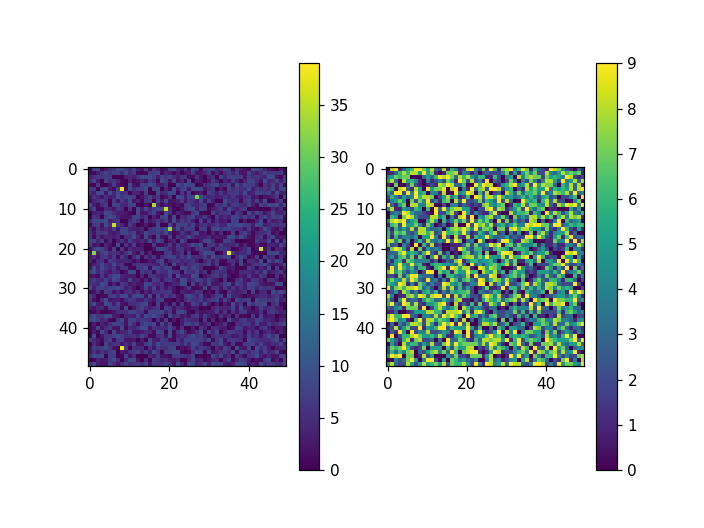

In [74]:
threshold = 0.3

where_above_threshold = np.where(image1 * threshold > median_of_image)

import copy
image_corrected = copy.copy(image1)
image_corrected[where_above_threshold] = median_of_image[where_above_threshold]

fig3, axs = plt.subplots(1,2)

plot1 = axs[0].imshow(image1)
fig.colorbar(plot1, ax=axs[0])

plot2 = axs[1].imshow(image_corrected)
fig.colorbar(plot2, ax=axs[1])


### Let's see how the threshold can affect the final image 

In [96]:
list_threshold = np.linspace(0, 1, 11)
#print(list_threshold)

list_image_corrected = []

for _threshold in list_threshold:
    where_above_threshold = np.where(image1 * _threshold > median_of_image)
    image_corrected = copy.copy(image1)
    image_corrected[where_above_threshold] = median_of_image[where_above_threshold]
    list_image_corrected.append(image_corrected)


<IPython.core.display.Javascript object>


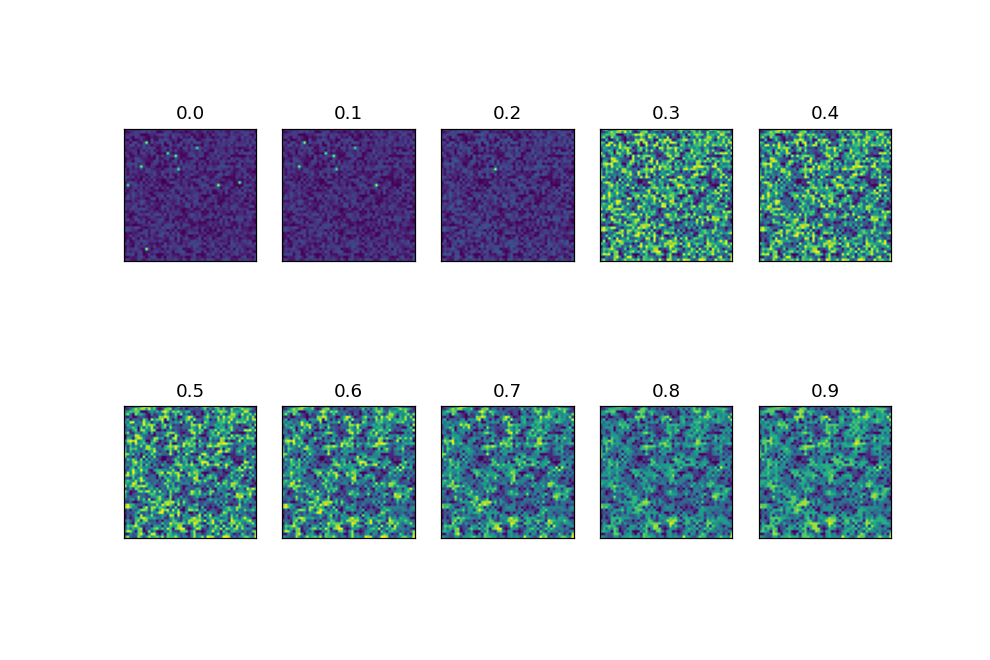

In [111]:

fig4, axs = plt.subplots(nrows=2,
                         ncols=5, 
                         figsize=(9,6),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, _image_corrected, _threshold in zip(axs.flat, list_image_corrected, list_threshold):
    ax.imshow(_image_corrected)
    ax.set_title("{:0.1f}".format(_threshold))



### Let's plot the difference original_image - image_corrected 

<IPython.core.display.Javascript object>


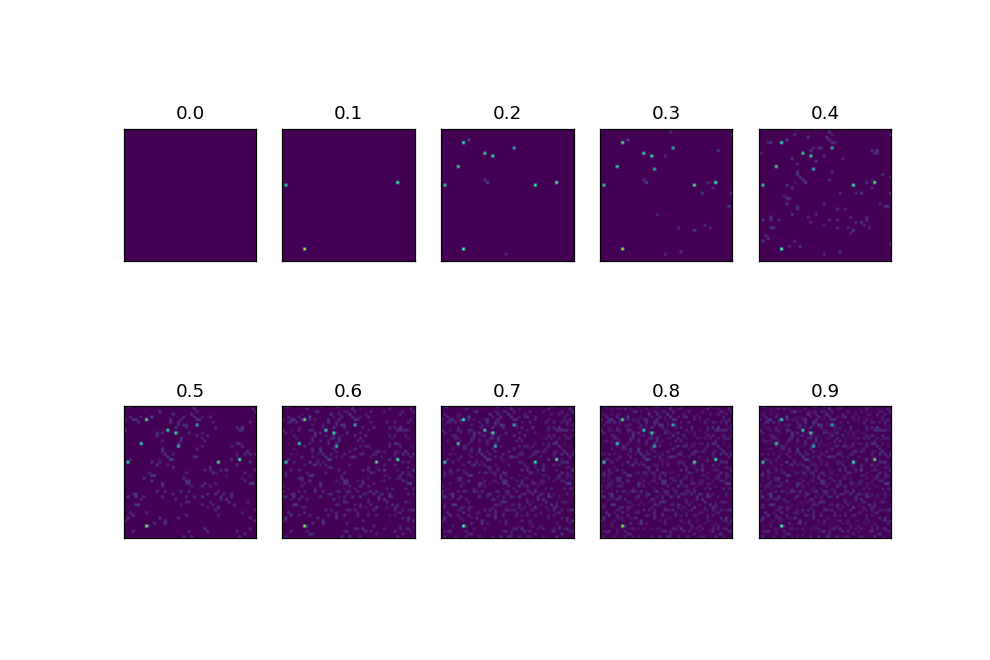

In [112]:
fig5, axs = plt.subplots(nrows=2,
                         ncols=5, 
                         figsize=(9,6),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, _image_corrected, _threshold in zip(axs.flat, list_image_corrected, list_threshold):
    ax.imshow(image1 - _image_corrected)
    ax.set_title("{:0.1f}".format(_threshold))

### let's calculate the percentage of pixels that have been affected 

<IPython.core.display.Javascript object>


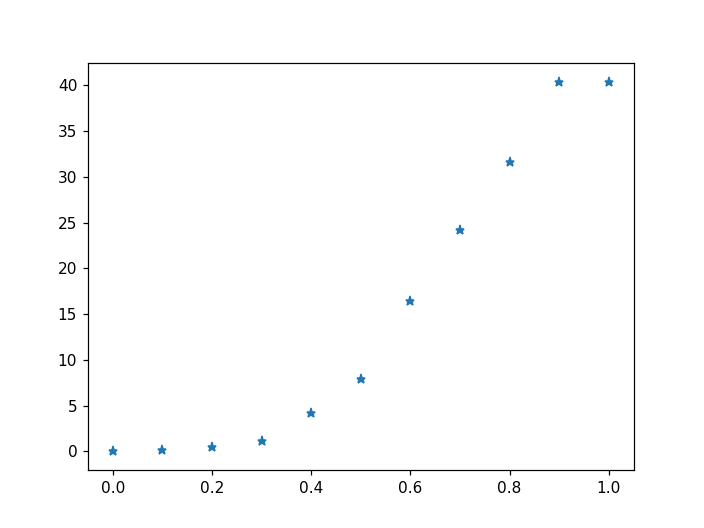

In [133]:
list_percentage_pixel_affected = []
for _image_corrected, _threshold in zip(list_image_corrected, list_threshold):
    difference = image1 - _image_corrected
    pixel_above_0 = np.where(difference > 0)
    number_of_pixels_affected = len(pixel_above_0[0])
    percentage_of_pixels_affected = (number_of_pixels_affected / total_nbr_of_pixels) * 100
    list_percentage_pixel_affected.append(percentage_of_pixels_affected)
    
fig6 = plt.figure(num="Percentage of pixels affected")
plt.plot(list_threshold, list_percentage_pixel_affected, "*")

# Playing with a real data set 

In [154]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from PIL import Image

import skimage
# from skimage.filters import median
from skimage.filters.rank import median
from skimage.morphology import disk

import scipy.ndimage.filters as flt2

<IPython.core.display.Javascript object>


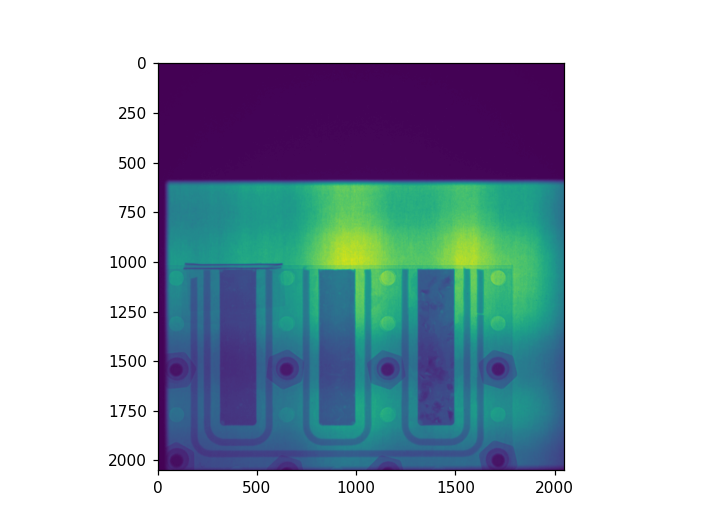

In [192]:
file_name = "data/real_data_set_to_test_outliers.tiff"
file_name = "data/real_data_set_to_test_outliers_2.tiff"
assert os.path.exists(file_name)

real_image = Image.open(file_name)
real_data = copy.deepcopy(np.asarray(real_image))

fig7 = plt.figure(num="Real data set")
plt.imshow(real_data)

threshold = 0.95

<IPython.core.display.Javascript object>


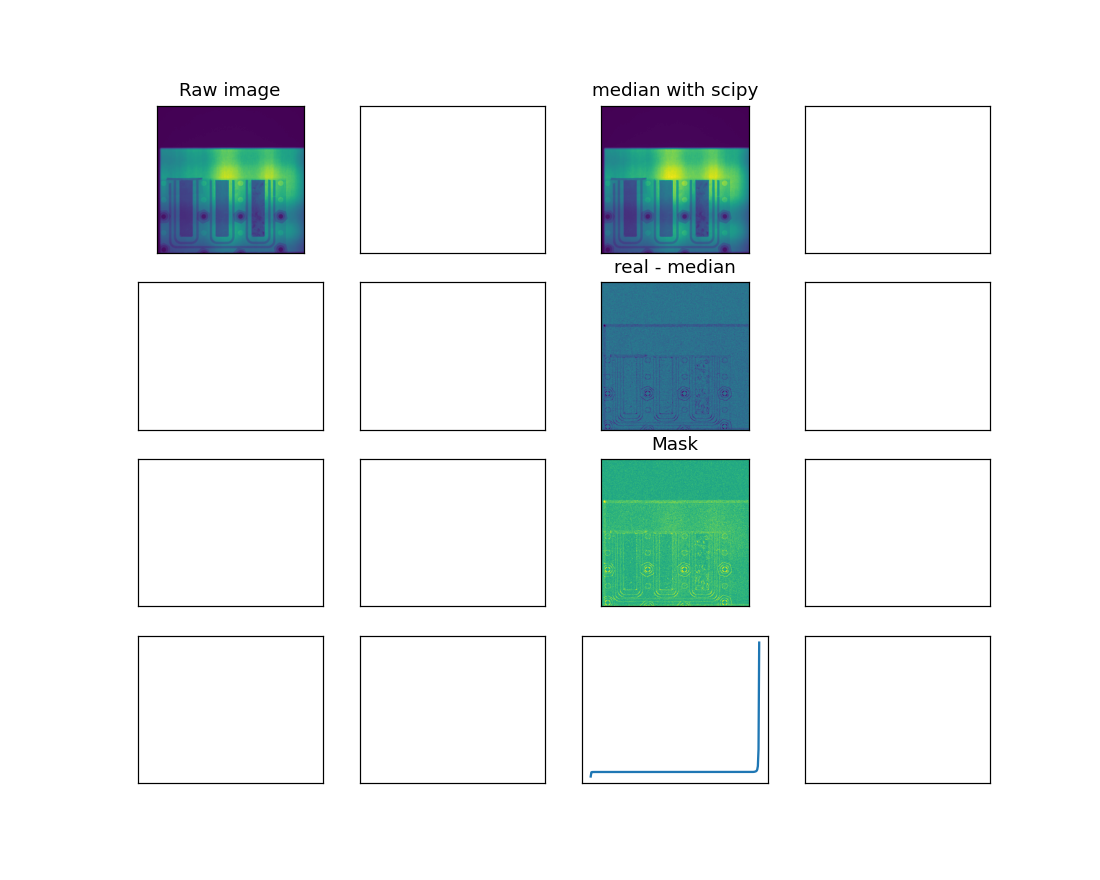

Using scipy median: full difference is 1.351823e+11


In [193]:
fig6, axs = plt.subplots(nrows=4,
                         ncols=4, 
                         figsize=(10,8),
                         subplot_kw={'xticks': [], 'yticks': []})

axes = axs.flat
axes[0].imshow(real_image)
axes[0].set_title("Raw image")

# # median_filter_image with scikit-image
# radius_of_disk = 1
# footprint = disk(radius_of_disk)
# median_of_image_1 = median(real_data, footprint=footprint, out=None)
# axes[1].imshow(median_of_image_1)
# axes[1].set_title("median with scikit")

# diff1 = np.abs(real_data - median_of_image_1)
# axes[5].imshow(diff1)
# axes[5].set_title("real - median")

# full_diff1 = np.sum(diff1)
# print(f"Using median scikit: full difference is {full_diff1:e}")

# # histogram
# nbins = 256

# h, dx = np.histogram(diff1, bins=nbins, density=True)
# ch = np.cumsum(h)
# ch = ch/np.max(ch)
# th = np.min(dx[np.where(ch>threshold)])
# mask = diff1 < th
# axes[9].imshow(mask)
# axes[9].set_title("Mask")

# axes[13].plot(dx[0:nbins], np.cumsum(h))


# median with scipy
median_of_image_2 = flt2.median_filter(real_data, 2)
axes[2].imshow(median_of_image_2)
axes[2].set_title("median with scipy")

diff2 = real_data - median_of_image_2
axes[6].imshow(diff1)
axes[6].set_title("real - median")

full_diff2 = np.sum(diff2)
print(f"Using scipy median: full difference is {full_diff2:e}")


# histogram
nbins = 256

h, dx = np.histogram(diff2, bins=nbins, density=True)
# histogram
nbins = 256

h, dx = np.histogram(diff2, bins=nbins, density=True)
ch = np.cumsum(h)
ch = ch/np.max(ch)
th = np.min(dx[np.where(ch>threshold)])
mask = diff1 < th
axes[10].imshow(mask)
axes[10].set_title("Mask")

axes[14].plot(dx[0:nbins], np.cumsum(h))



